### 2View Geometry

In [132]:
import copy
import numpy as np

def run_test_triangulation():
    N = 4                    # Number of 3-D points
    P = np.random.rand(4,N)   # Homogeneous coordinates of 3-D points

    # test linear triangulation
    P[2, :] = P[2, :] * 5 + 10
    P[3, :] = 1

    M1 = np.array([[500, 0, 320, 0],
                   [0, 500, 240, 0],
                   [0, 0, 1, 0]], dtype=np.float)

    M2 = np.array([[500, 0, 320, -100],
                   [0, 500, 240, 0],
                   [0, 0, 1, 0]], dtype=np.float)

    # project points onto the image plane
    p1 = M1 @ P
    p2 = M2 @ P

    
    P_est = linear_triangulation(p1,p2,M1,M2);
    print("Ground truth")
    print(f"P={P}")
    print("Estimated")
    print(f"{P_est}")
    print("Residuals")
    print(f"P_est-P=\n{P_est - P}")
    

def skew(vector):
    """
    this function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)

    :param vector: An array like vector to create the skew symmetric cross product matrix for
    :return: A numpy array of the skew symmetric cross product vector
    """

    return np.array([[0, -vector[2], vector[1]], 
                     [vector[2], 0, -vector[0]], 
                     [-vector[1], vector[0], 0]])

def linear_triangulation(p1, p2, M1, M2) -> np.ndarray:
    """
    p1: first set of keypoints [3 x N]
    p2: matching keypoints [3 x N]
    M1: first projection matrix
    M2: second projection matrix
    return: [4 x N] matrix of triangulated points in homogeneous coordinates
    """
    N = p1.shape[1]
    assert N == p2.shape[1]
    
    points = np.zeros((4, N))
    points[3, :] = np.ones((1, N))
    
    for i in range(N):    
        A = np.vstack((skew(p1[:, i]) @ M1, skew(p2[:, i]) @ M2))
        u, s, vh = np.linalg.svd(A, full_matrices=True)

        # the solution is the eigenvector corresponding to the minimum non zero eigenvalue
        # which is the corresponding column in v
        points[:, i] = vh[-1, :].T
        points[:, i] /= points[3, i]  # make the points homogeneous

       
    return points
 
run_test_triangulation()
 

Ground truth
P=[[ 0.75479623  0.26434587  0.21296866  0.02683499]
 [ 0.07281163  0.71539329  0.8594498   0.9704056 ]
 [12.88584997 14.45461644 14.34166336 10.51053966]
 [ 1.          1.          1.          1.        ]]
Estimated
[[ 0.75479623  0.26434587  0.21296866  0.02683499]
 [ 0.07281163  0.71539329  0.8594498   0.9704056 ]
 [12.88584997 14.45461644 14.34166336 10.51053966]
 [ 1.          1.          1.          1.        ]]
Residuals
P_est-P=
[[ 7.77156117e-16  3.33066907e-15  1.48769885e-14  1.21985755e-14]
 [-1.52655666e-16  2.99760217e-15  9.88098492e-15  9.99200722e-15]
 [ 1.24344979e-14  3.55271368e-15 -2.84217094e-14 -1.95399252e-14]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]


In [133]:
def fundamental_eight_point(p1, p2, normalized=False):
    N = p1.shape[1]    
    
    # Initialize matrices for normalization to identity (not changing result 
    # when not normalizing)
    T1 = np.eye(3)
    T2 = np.eye(3)
    if normalized: 
        mu_1 = np.mean(p1[:2, :], axis=1)
        mu_2 = np.mean(p2[:2, :], axis=1)
        print(f"mean 1 = {mu_1}")
        print(f"mean 2 = {mu_2}")
        
        delta_1 = (p1[:2, :].T - mu_1).T # numpy can subtract only row-wise
        delta_2 = (p2[:2, :].T - mu_2).T # numpy can subtract only row-wise
        
        sigma_1 = np.mean(np.sum(delta_1 ** 2, axis=0) ** 0.5) # mean of colwise norm
        sigma_2 = np.mean(np.sum(delta_2 ** 2, axis=0) ** 0.5)
        print(f"sigma 1 = {sigma_1}")
        print(f"sigma 2 = {sigma_2}")
        
        s1 = 2 ** 0.5 / sigma_1
        s2 = 2 ** 0.5 / sigma_2
        
        T1[0, 0] = s1
        T1[1, 1] = s1
        T1[0, 2] = -s1 * mu_1[0]
        T1[1, 2] = -s1 * mu_1[1]
        
        T2[0, 0] = s2
        T2[1, 1] = s2
        T2[0, 2] = -s2 * mu_2[0]
        T2[1, 2] = -s2 * mu_2[1]
        
        p1_tmp = T1 @ p1
        p2_tmp = T2 @ p2
    else:
        p1_tmp = copy.deepcopy(p1)
        p2_tmp = copy.deepcopy(p2)
        
    Q = np.vstack([np.kron(p1_tmp[:, i], p2_tmp[:, i]).T for i in range(N)])
    u, s, vh = np.linalg.svd(Q, full_matrices=True)
    fvect = vh[-1, :].T
    
    print(f"f vectorized={fvect}")
    F = fvect.reshape(3, 3).T   # reshape colwise
    print(f"F=\n{F}")
    
    u, s, vh = np.linalg.svd(F, full_matrices=True)
    s[-1] = 0
    F_corr = u @ np.diag(s) @ vh
    print(f"F corrected=\n{F_corr}")
    return T2.T @ F @ T1

def dist_point_to_epipolar_line(F, p1, p2):
    l1 = F.T @ p2
    l2 = F @ p1
    
    # coefficients of a line: ax + by + c -> [a, b, c]
    # distance point to line: (ax0 + by0 + c) / sqrt((a**2 + b**2))
    # since the point is already in homogenous coordinates we can compute the previous 
    # equation as p.dot(l) / (norm(l[:2]))
    d1 = p1.T @ l1
    d2 = p2.T @ l2
    
    return np.mean(np.square(d1) + np.square(d2))

def estimate_essential_matrix(p1, p2, K1, K2):
    F = fundamental_eight_point(p1, p2, normalized=True)
    return K2.T @ F @ K1
    
def run_test_eight_point():
    print("Running the 8 point algorithm test")   
    N = 40                     # Number of 3-D points (TODO set back to 40, just for better priting)
    X = np.random.rand(4,N)   # Homogeneous coordinates of 3-D points

    # Simulated scene with error-free correspondences
    X[2, :] = X[2, :] * 5 + 10;
    X[3, :] = 1;

    M1 = np.array([[500, 0, 320, 0],
                   [0, 500, 240, 0],
                   [0, 0, 1, 0]], dtype=np.float)

    M2 = np.array([[500, 0, 320, -100],
                   [0, 500, 240, 0],
                   [0, 0, 1, 0]], dtype=np.float)

    print(f"Points are\n{X}")
    print("-------------------------------------------")
    # Project points in the image plane
    x1 = M1 @ X
    x2 = M2 @ X

    sigma = 1e-1
    noisy_x1 = x1 + sigma * np.random.rand(*x1.shape)
    noisy_x2 = x2 + sigma * np.random.rand(*x2.shape)

    # Fundamental matrix estimation via the 8-point algorithm
    # Estimate fundamental matrix
    # Call the 8-point algorithm on inputs x1,x2
    print("-------------------------------------------")
    print(f"Computing unnormalized fundamental matrix")
    F = fundamental_eight_point(x1,x2)

    # Check the epipolar constraint x2(i).' * F * x1(i) = 0 for all points i.
    cost_algebraic = np.linalg.norm( sum(x2.T @ (F @ x1)) ) / np.sqrt(N)
    cost_dist_epi_line = dist_point_to_epipolar_line(F,x1,x2)

    print(f"Noise-free correspondences")
    print(f"Algebraic error: {cost_algebraic}")
    print(f"Geometric error: {cost_dist_epi_line}")

    # Test with noise:

    # Estimate fundamental matrix
    # Call the 8-point algorithm on noisy inputs x1,x2
    print("-------------------------------------------")
    print(f"Computing unnormalized fundamental matrix with noisy points.")
    F = fundamental_eight_point(noisy_x1,noisy_x2)

    # Check the epipolar constraint x2(i).' * F * x1(i) = 0 for all points i.
    cost_algebraic = np.linalg.norm( sum(noisy_x2.T @ (F @ noisy_x1)) ) / np.sqrt(N)
    cost_dist_epi_line = dist_point_to_epipolar_line(F,noisy_x1,noisy_x2)

    print(f"Noisy correspondences (sigma={sigma}), with fundamental_eight_point")
    print(f"Algebraic error: {cost_algebraic}")
    print(f"Geometric error: {cost_dist_epi_line}")


    # Normalized 8-point algorithm
    # Call the normalized 8-point algorithm on inputs x1,x2
    print("-------------------------------------------")
    print(f"Computing normalized fundamental matrix with noisy points.")
    Fn = fundamental_eight_point(noisy_x1,noisy_x2, normalized=True)

    # Check the epipolar constraint x2(i).' * F * x1(i) = 0 for all points i.
    cost_algebraic = np.linalg.norm( sum(noisy_x2.T @ (Fn @ noisy_x1)) ) / np.sqrt(N)
    cost_dist_epi_line = dist_point_to_epipolar_line(Fn,noisy_x1,noisy_x2)


    print(f"Noisy correspondences (sigma={sigma}), with fundamental_eight_point normalized")
    print(f"Algebraic error: {cost_algebraic}")
    print(f"Geometric error: {cost_dist_epi_line}")
    
run_test_eight_point()

Running the 8 point algorithm test
Points are
[[3.40509463e-01 7.81833172e-01 5.45788858e-02 8.48766544e-01
  8.77664761e-01 9.39166139e-02 7.53781604e-01 5.45348943e-01
  9.30998413e-01 1.41381415e-01 5.98216594e-01 1.30070070e-01
  2.67750405e-01 6.65831509e-01 3.85830845e-01 7.02352155e-01
  5.79300112e-01 9.75453211e-01 3.13566195e-03 8.10420023e-01
  3.24476711e-01 3.79663103e-01 7.70941745e-01 5.44116391e-02
  2.41723404e-01 2.29955606e-01 5.92707478e-01 1.62609425e-01
  6.25891874e-01 5.74741547e-01 7.56494902e-01 4.35246365e-01
  2.77303178e-02 1.59694412e-01 2.02599076e-01 4.29654574e-02
  4.03257789e-01 8.99632797e-03 2.72960631e-01 1.37821631e-01]
 [1.98615400e-01 8.56049663e-01 4.05562333e-01 5.60846084e-01
  8.98429617e-01 9.88725211e-01 5.56160097e-01 9.69260798e-01
  2.18037071e-01 3.37832721e-01 7.51553820e-01 7.50682085e-01
  7.77726812e-01 7.71688740e-01 1.41150936e-02 1.74207873e-01
  3.13243324e-01 2.25980090e-01 5.89189952e-01 3.86121340e-01
  3.25033321e-01 5.6625

In [145]:
def decompose_essential_matrix(E):
    u, s, vh = np.linalg.svd(E, full_matrices=True)
    W = np.zeros((3, 3), dtype=np.float)
    W[0, 1] = -1
    W[1, 0] = 1
    W[2, 2] = 1
    
    u3 = u[:, -1]
    R1 = u @ W @ vh
    R2 = u @ W.T @ vh
    
    # Make sure that rotation matrices are valid
    if np.linalg.det(R1) < 0:
        R1 = -R1
    if np.linalg.det(R2) < 0:
        R2 = -R2
    
    # make sure translation vector is not zero
    u3_norm = np.linalg.norm(u3)
    if u3_norm < 1e-6:
        u3 = u3/u3_norm
        
    return (R1, R2), (u3, -u3)

def disambiguate_relative_pose(rots, trans, p1, p2, K1, K2):
    """
    Finds the correct relative camera pose (among
    four possible configurations) by returning the one that yields points
    lying in front of the image plane (with positive depth).

    Arguments:
      rots -  2 3x3: the two possible rotations returned by decompose_essential_matrix
      u3   -  2 3x1 vectors with the translation information returned by decompose_essential_matrix
      p1   -  3xN homogeneous coordinates of point correspondences in image 1
      p2   -  3xN homogeneous coordinates of point correspondences in image 2
      K1   -  3x3 calibration matrix for camera 1
      K2   -  3x3 calibration matrix for camera 2
    Returns:
      R -  3x3 the correct rotation matrix
      T -  3x1 the correct translation vector
    where [R|t] = T_C2_C1 = T_C2_W is a transformation that maps points
    from the world coordinate system (identical to the coordinate system of camera 1)
    to camera 2.
    """
    M1 = np.zeros((3, 4))
    M1[:, :3] = np.eye(3)
    M1 = K1 @ M1
    M2 = np.zeros((3, 4))
    R_est, t_est = rots[0], trans[0]
    
    frontal_points = -1
    for R in rots:
        for t in trans:
            M2[:, :3] = R
            M2[:, 3] = t
            M2 = K2 @ M2
            P_est = linear_triangulation(p1, p2, M1, M2)
            frontal_points_cam_1 = np.sum(P_est[2, :] > 0)
            
            T_C2_C1 = np.hstack((R, np.expand_dims(t, axis=1)))
            P_est_2 = T_C2_C1 @ P_est
            frontal_points_cam_2 = np.sum(P_est_2[2, :] > 0)
            
            if  (frontal_points_cam_1 + frontal_points_cam_2) > frontal_points:
                R_est = R
                t_est = t
                frontal_points = (frontal_points_cam_1 + frontal_points_cam_2)
    
    # make sure dim is (3 x 1) and not only (3,)
    if len(t_est.shape) == 1:
        t_est = np.expand_dims(t_est, axis=1)
    return R_est, t_est

### Structure from Motion pipeline

mean 1 = [837.7277381  441.49559524]
mean 2 = [855.7525     439.56772619]
sigma 1 = 409.6599440151764
sigma 2 = 411.0185525482251
f vectorized=[-5.57777752e-05  3.40438064e-02 -9.33501600e-03 -4.74462240e-03
  3.58443514e-04 -7.08678754e-01 -5.14551505e-04  7.04628984e-01
 -1.84026356e-03]
F=
[[-5.57777752e-05 -4.74462240e-03 -5.14551505e-04]
 [ 3.40438064e-02  3.58443514e-04  7.04628984e-01]
 [-9.33501600e-03 -7.08678754e-01 -1.84026356e-03]]
F corrected=
[[-8.66810971e-05 -4.74421921e-03 -5.13058633e-04]
 [ 3.40437844e-02  3.58443800e-04  7.04628985e-01]
 [-9.33480913e-03 -7.08678757e-01 -1.84027355e-03]]


<IPython.core.display.Javascript object>


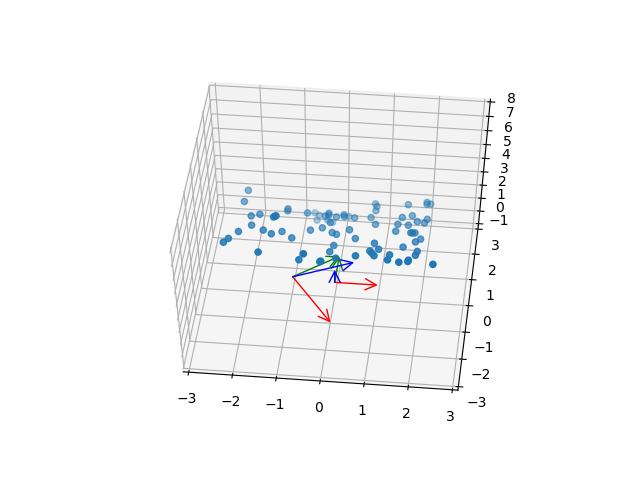

<IPython.core.display.Javascript object>


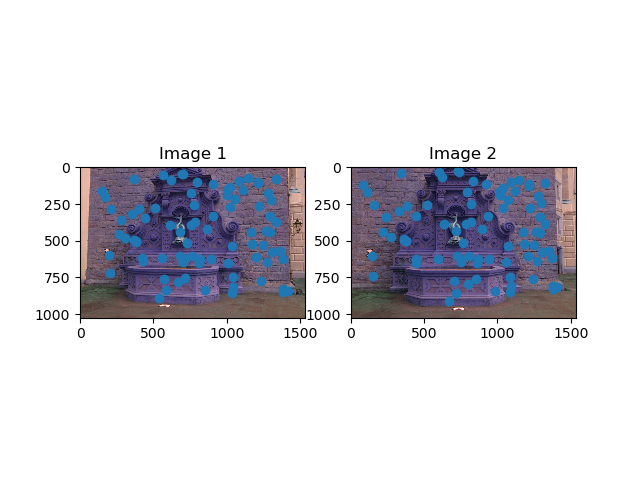

Text(0.5, 1.0, 'Image 2')

In [154]:
%matplotlib notebook

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    """ 
    Utility class later used to draw 3d frame 
    """
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

def plot_coordinate_frame(ax, R, t):
    """
    Function to plot a coordinate frame in the axis ax
    """
    arrow_prop_dict = dict(mutation_scale=20, arrowstyle='->', shrinkA=0, shrinkB=0)

    # the start of the frame is where the translation vector is pointing to
    s = np.hstack((t, t, t))
    
    # the end of the shaft is in the direction of each column in R shifted of t
    e = (R.T + t).T # numpy can sum only rowwise
    
    ix = Arrow3D([s[0, 0], e[0, 0]], [s[1, 0], e[1, 0]], [s[2, 0], e[2, 0]], **arrow_prop_dict, color='r')
    iy = Arrow3D([s[0, 1], e[0, 1]], [s[1, 1], e[1, 1]], [s[2, 1], e[2, 1]], **arrow_prop_dict, color='g')
    iz = Arrow3D([s[0, 2], e[0, 2]], [s[1, 2], e[1, 2]], [s[2, 2], e[2, 2]], **arrow_prop_dict, color='b')
    
    ax.add_artist(ix)
    ax.add_artist(iy)
    ax.add_artist(iz)
    
    
###########################################
#                Pipeline
###########################################

#######################################
# Read images, calibration and matches
#######################################

img_1 = cv2.imread('../data/0001.jpg');
img_2 = cv2.imread('../data/0002.jpg');

K = np.array([[1379.74, 0, 760.35],
              [0, 1382.08, 503.41],
              [0, 0, 1 ]], dtype=np.float);

# Load outlier-free point correspondences

p1 = []
with open('../data/matches0001.txt') as f:
    p1 = [[float(x) for x in line.split()] for line in f]

p2 = []
with open('../data/matches0002.txt') as f:
    p2 = [[float(x) for x in line.split()] for line in f]


p1 = np.asarray(p1)
p1 = np.vstack((p1, np.ones((1, p1.shape[1]))))

p2 = np.asarray(p2)
p2 = np.vstack((p2, np.ones((1, p2.shape[1]))))

#######################################
# Estimage E, extract R and T from it
#######################################

# Estimate the essential matrix E using the 8-point algorithm
E = estimate_essential_matrix(p1, p2, K, K)

# Extract the relative camera positions (R,T) from the essential matrix
rots, trans = decompose_essential_matrix(E)

# Disambiguate among the four possible configurations
R_C2_W, T_C2_W = disambiguate_relative_pose(rots, trans, p1,p2, K, K)


#######################################
# Triangulate correspondences in 3D
#######################################

# Triangulate a point cloud using the final transformation (R,T)
M1 = K @ np.eye(3, 4);
M2 = K @ np.hstack((R_C2_W, T_C2_W)) 
P = linear_triangulation(p1, p2, M1, M2)

#######################################
# Plots
#######################################

# Visualize the 3-D scene
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# R,T should encode the pose of camera 2, such that M1 = [I|0] and M2=[R|t]

# P is a [4xN] matrix containing the triangulated point cloud (in
# homogeneous coordinates), given by the function linear_triangulation
ax.scatter(P[0, :], P[1, :], P[2, :])

# Display camera pose

plot_coordinate_frame(ax, np.eye(3), np.zeros((3,1)))

center_cam2_W = -R_C2_W.T @ T_C2_W
plot_coordinate_frame(ax, R_C2_W.T, center_cam2_W)

# default to top view
# ax.view_init(azim=0, elev=90)
ax.set_xlim3d(-3, 3)
ax.set_ylim3d(-3, 3)
ax.set_zlim3d(-1, 8)
ax.grid(True)

# Display matched points
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_1)
axs[0].scatter(p1[0, :], p1[1, :])
axs[0].set_title('Image 1')

axs[1].imshow(img_2)
axs[1].scatter(p2[0, :], p2[1, :])
axs[1].set_title('Image 2')